In [77]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import spacy
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score

In [2]:
nlp = spacy.load("en_core_sci_sm")

c:\Users\zhenrui.yu\AppData\Local\miniconda3\envs\cancer-surgery-nlp\lib\site-packages\spacy\language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [3]:
cancer_text = pd.read_csv("../data/train_data_01.csv") 
cancer_text = cancer_text.rename(columns={"site": "target"})
procedrue_text = cancer_text[["ha_procedure_description", "target"]]
procedrue_text = procedrue_text.dropna().drop_duplicates()
procedrue_text 

,ha_procedure_description,target
0,NEPHRECTOMY (ADULT),non_cancer
1,"FUSION - INSTRUMENTED, PLATING - POSTERIOR CER...",non_cancer
2,THERMABLATION - ENDOMETRIAL #2,non_cancer
3,PALATE CLOSURE FISTULA,non_cancer
4,CORRECTION OF ECTROPION,non_cancer
...,...,...
86399,INSERTION OF BRONCHIAL STENT,non_cancer
86401,RECTAL HERNIA REPAIR WITH MESH,non_cancer
86439,Z_EXCISION-BONE-FEMUR-PROXIMAL,non_cancer
86512,INSERTION STIMULATOR SPINAL CORD DORSAL ROOT G...,non_cancer


In [4]:
# Preprocessing function using scispaCy (tokenization + lemmatization)
def clean_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

procedrue_text["clean_text"] = procedrue_text["ha_procedure_description"].apply(clean_text)
procedrue_text

,ha_procedure_description,target,clean_text
0,NEPHRECTOMY (ADULT),non_cancer,nephrectomy adult
1,"FUSION - INSTRUMENTED, PLATING - POSTERIOR CER...",non_cancer,FUSION INSTRUMENTED PLATING POSTERIOR CERVICAL
2,THERMABLATION - ENDOMETRIAL #2,non_cancer,THERMABLATION endometrial 2
3,PALATE CLOSURE FISTULA,non_cancer,PALATE CLOSURE FISTULA
4,CORRECTION OF ECTROPION,non_cancer,correction ectropion
...,...,...,...
86399,INSERTION OF BRONCHIAL STENT,non_cancer,insertion bronchial stent
86401,RECTAL HERNIA REPAIR WITH MESH,non_cancer,rectal hernia REPAIR mesh
86439,Z_EXCISION-BONE-FEMUR-PROXIMAL,non_cancer,Z_EXCISION-BONE-FEMUR-PROXIMAL
86512,INSERTION STIMULATOR SPINAL CORD DORSAL ROOT G...,non_cancer,insertion stimulator spinal CORD DORSAL ROOT G...


In [ ]:
# Load Bio_ClinicalBERT from Hugging Face
device = torch.device("cpu")  # CPU only setup
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)
bert_model.eval()

# Function to get BERT [CLS] embedding for a sentence
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs.to(device))
    cls_embedding = outputs.last_hidden_state[0][0].cpu().numpy()
    return cls_embedding

# Generate embeddings for all cleaned texts
procedrue_text["embedding"] = procedrue_text["clean_text"].apply(get_bert_embedding)
procedrue_text

,ha_procedure_description,target,clean_text,embedding
0,NEPHRECTOMY (ADULT),non_cancer,nephrectomy adult,"[0.09272951, 0.3482019, -0.111585855, -0.17339..."
1,"FUSION - INSTRUMENTED, PLATING - POSTERIOR CER...",non_cancer,FUSION INSTRUMENTED PLATING POSTERIOR CERVICAL,"[0.46684462, 0.41326842, -0.19633944, 0.202530..."
2,THERMABLATION - ENDOMETRIAL #2,non_cancer,THERMABLATION endometrial 2,"[0.28898898, 0.6268676, -0.027707264, 0.018289..."
3,PALATE CLOSURE FISTULA,non_cancer,PALATE CLOSURE FISTULA,"[0.68323284, 0.12657847, -0.12516877, -0.36157..."
4,CORRECTION OF ECTROPION,non_cancer,correction ectropion,"[0.07993032, 0.51494104, -0.0652876, 0.1492326..."
...,...,...,...,...
86399,INSERTION OF BRONCHIAL STENT,non_cancer,insertion bronchial stent,"[0.39713186, 0.49669862, -0.1869466, -0.029087..."
86401,RECTAL HERNIA REPAIR WITH MESH,non_cancer,rectal hernia REPAIR mesh,"[0.120326295, 0.59260404, -0.17677714, 0.01118..."
86439,Z_EXCISION-BONE-FEMUR-PROXIMAL,non_cancer,Z_EXCISION-BONE-FEMUR-PROXIMAL,"[0.9800946, 0.024293821, -0.058278404, 0.22533..."
86512,INSERTION STIMULATOR SPINAL CORD DORSAL ROOT G...,non_cancer,insertion stimulator spinal CORD DORSAL ROOT G...,"[0.48872697, 0.55004376, -0.00245859, 0.043297..."


In [10]:
# Prepare features and target arrays
procedrue_text['target_binary'] = procedrue_text['target'].apply(lambda x: 0 if x == 'cancer' else 1)


In [13]:
procedrue_text['target_binary'] = procedrue_text['target'].apply(lambda x: 0 if x == 'non_cancer' else 1)
percentage = procedrue_text['target_binary'].value_counts(normalize=True) * 100
print(percentage)

target_binary
0    96.514896
1     3.485104
Name: proportion, dtype: float64


In [14]:
X = list(procedrue_text["embedding"])
y = procedrue_text['target_binary'] 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Logestic Regression

In [39]:
# Split data (20% test size, stratified)


# Train logistic regression with balanced class weights
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
probs = clf.predict_proba(X_test)[:, 1]
threshold = 0.5  # lower than 0.5 to increase recall
y_pred = (probs >= threshold).astype(int)
print(confusion_matrix(y_test, y_pred, labels=[1, 0]))
print(classification_report(y_test, y_pred))

[[  48   39]
 [ 293 2111]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2404
           1       0.14      0.55      0.22        87

    accuracy                           0.87      2491
   macro avg       0.56      0.71      0.58      2491
weighted avg       0.95      0.87      0.90      2491



### Random Forest

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train_pca, y_train)


In [62]:
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train_under, y_train_under)

RandomForestClassifier(random_state=42)

In [63]:
probs = clf.predict_proba(X_test_pca)[:, 1]
threshold = 0.4  # lower than 0.5 to increase recall
y_pred = (probs >= threshold).astype(int)
print(confusion_matrix(y_test, y_pred, labels=[1, 0]))
print(classification_report(y_test, y_pred))

[[  76   11]
 [1255 1149]]
              precision    recall  f1-score   support

           0       0.99      0.48      0.64      2404
           1       0.06      0.87      0.11        87

    accuracy                           0.49      2491
   macro avg       0.52      0.68      0.38      2491
weighted avg       0.96      0.49      0.63      2491



In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [25]:
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_resampled, y_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [26]:
probs = clf.predict_proba(X_test)[:, 1]
threshold = 0.5  # lower than 0.5 to increase recall
y_pred = (probs >= threshold).astype(int)
print(confusion_matrix(y_test, y_pred, labels=[0, 1]))
print(classification_report(y_test, y_pred))

[[2162  242]
 [  42   45]]
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2404
           1       0.16      0.52      0.24        87

    accuracy                           0.89      2491
   macro avg       0.57      0.71      0.59      2491
weighted avg       0.95      0.89      0.91      2491



In [30]:
len(X[1])

768

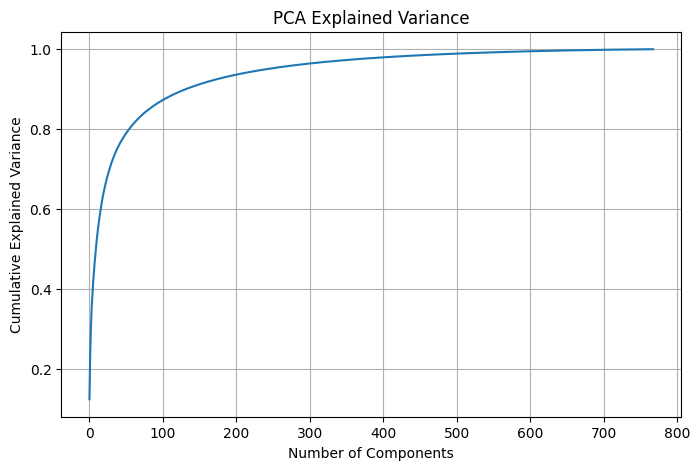

In [ ]:
pca = PCA().fit(X_train) 

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [75]:
from collections import Counter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (_, val_index) in enumerate(skf.split(X_train, y_train)):
    y_val_fold = np.array(y_train)[val_index]
    print(f"Fold {i+1} class distribution:", Counter(y_val_fold))

Fold 1 class distribution: Counter({0: 1923, 1: 70})
Fold 2 class distribution: Counter({0: 1923, 1: 70})
Fold 3 class distribution: Counter({0: 1923, 1: 69})
Fold 4 class distribution: Counter({0: 1923, 1: 69})
Fold 5 class distribution: Counter({0: 1923, 1: 69})


In [80]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the pipeline
pipeline = ImbPipeline([
    ('pca', PCA(n_components=300)),  # tune this if needed
    ('undersample', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Hyperparameter grid for Random Forest
param_grid = {
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [5, 10, 15],         # shallower trees
    'rf__min_samples_split': [5, 10],     # require more samples to split
    'rf__min_samples_leaf': [5, 10],      # larger leaves
    'rf__max_features': ['sqrt'],          # limit features per split
}

# Grid search using RECALL as the scoring metric
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output best results
print("Best parameters:", grid_search.best_params_)
print("Best recall score (cross-validated):", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 150}
Best recall score (cross-validated): 0.7609937888198758


In [70]:
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train_pca, y_train)

clf = RandomForestClassifier(random_state=42, n_estimators=200, max_depth = 10, min_samples_split = 2, min_samples_leaf = 1)
clf.fit(X_train_under, y_train_under)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [79]:
y_train_pred = clf.predict(X_train_under)
recall_score(y_train_pred, y_train_under)

0.9857549857549858

In [73]:
probs = clf.predict_proba(X_test_pca)[:, 1]
threshold = 0.4  # lower than 0.5 to increase recall
y_pred = (probs >= threshold).astype(int)
print(confusion_matrix(y_test, y_pred, labels=[1, 0]))
print(classification_report(y_test, y_pred))

[[  76   11]
 [1257 1147]]
              precision    recall  f1-score   support

           0       0.99      0.48      0.64      2404
           1       0.06      0.87      0.11        87

    accuracy                           0.49      2491
   macro avg       0.52      0.68      0.38      2491
weighted avg       0.96      0.49      0.63      2491

